<a href="https://colab.research.google.com/github/naenumtou/creditrisk/blob/main/modifySampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Set auto reload
%reload_ext autoreload
%autoreload 2

In [ ]:
# Change directory to Google Drive
%cd /content/drive/My Drive/Colab Notebooks/BScore

/content/drive/My Drive/Colab Notebooks/BScore


In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

# Config
%config InlineBackend.figure_format = 'retina' #Retina display
plt.style.use('seaborn-deep') #Plot style
pd.set_option('display.max_columns', None) #Max column width

In [ ]:
# Import data
transaction = pd.read_parquet(
    'behaviourFactors.parquet',
    engine = 'pyarrow'
)
print(f'Total rows: {transaction.shape[0]}')
print(f'Total columns: {transaction.shape[1]}')

Total rows: 792456
Total columns: 333


In [ ]:
# Prepare dataset before create sample
# Create year of observation
transaction['Year'] = transaction['AS_OF_DATE'].dt.year

# Create default flag (0, 1)
# Using 60+ DPD as default target
transaction['dfFlag'] = np.where(
    transaction['del'].ge(3),
    1,
    0
)

# Create forward default
# Using 6-Months as performance window
lag = 6

for i in range(1, lag + 1):
  transaction[f'dfFlag{i}'] = transaction.groupby(
      ['Br_Con']
  )['dfFlag'].shift(-i).astype(np.float32)
  print(f'Column: {transaction.columns[-1]} created')

Column: dfFlag1 created
Column: dfFlag2 created
Column: dfFlag3 created
Column: dfFlag4 created
Column: dfFlag5 created
Column: dfFlag6 created


In [ ]:
# Create ever 6-Months default status
transaction['everDefault6'] = np.where(
    transaction.loc[:, 'dfFlag1':'dfFlag6'].max(axis = 1).eq(1),
    1,
    0
)

In [ ]:
# Exclusion rules
# 1: Newly open contract
'''
Using 12-Months backward window to create factors.
Thus, any contract with less than 12-Month backward window (MOB < 12 and Monthkey <= 12) is invalid.
'''
transaction = transaction[
                          transaction['Br_Con'].isin(
                              transaction.groupby(
                                  ['Br_Con']
                              )[['MOB', 'Monthkey']].max().query(
                                  """
                                  MOB >= 12 & \
                                  Monthkey > 12
                                  """
                              ).index
                          )
]

# 2: MOB < 12 and Monthkey < 12 (Performance window used for create factors)
# 3: Bad at observation point (Defaulted transaction)
# 4: Less than 6-Months forward performance window
transaction = transaction.query(
    "MOB >=12 & Monthkey >= 12 & dfFlag != 1 & Monthkey <= Monthkey.max() - 6"
)

# 5: Last transaction (No probability to observed)
transaction = transaction[transaction['dfFlag1'].notnull()]

# Drop lagged columns
transaction = transaction.drop(
    transaction.loc[:, 'dfFlag1':f'dfFlag{lag - 1}'],
    axis = 1
)

print(f'Total rows: {transaction.shape[0]}')
print(f'Total columns: {transaction.shape[1]}')

Total rows: 419710
Total columns: 337


In [ ]:
# Normal train/test split
train, test = train_test_split(
    transaction,
    test_size = 0.3,
    stratify = transaction['everDefault6'],
    random_state = 101
)
print(f'Training size: {train.shape[0]}')
print(f'Testing size: {test.shape[0]}')

Training size: 293797
Testing size: 125913


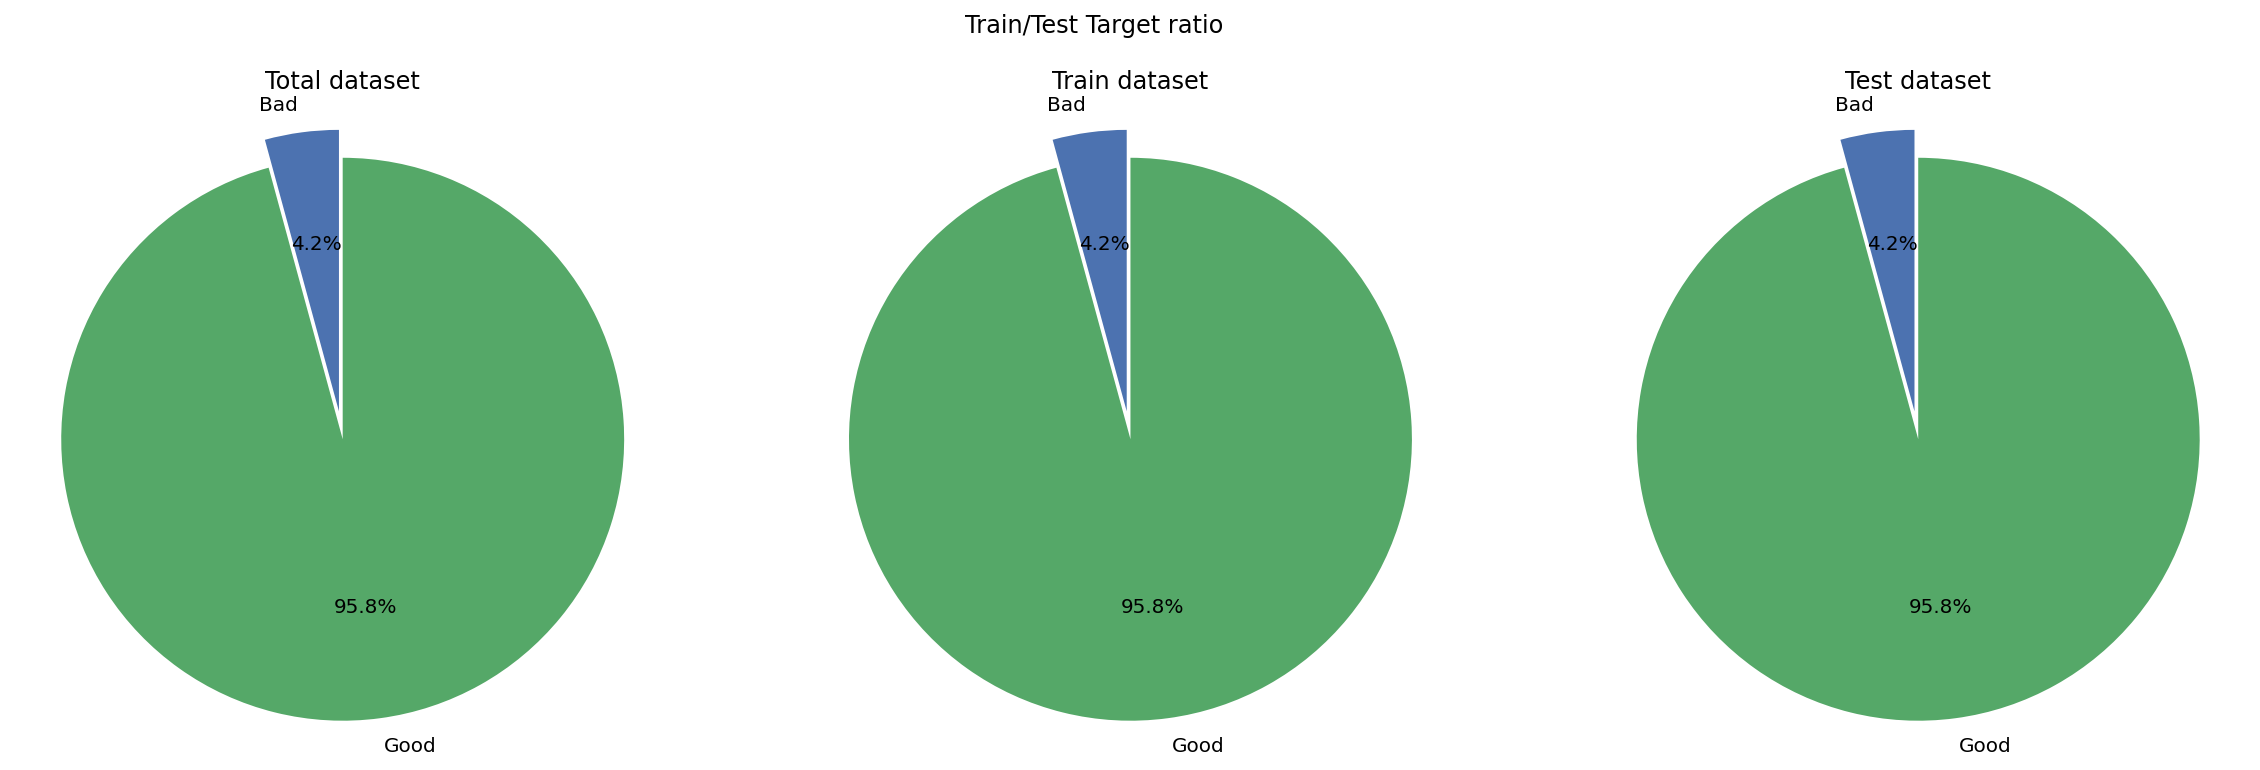

In [ ]:
# Define plot sample function
def plotSample(allset, trainset, testset):
  data = pd.concat(
      [
       allset['everDefault6'].rename('Total'),
       trainset['everDefault6'].rename('Train'),
       testset['everDefault6'].rename('Test')
      ],
      axis = 1
  )
  fig, axs = plt.subplots(1, 3, figsize = (20, 6))
  axs = axs.ravel()
  fig.suptitle('Train/Test Target ratio')
  for i, col in enumerate(data.columns):
    sizes = [
             data[col].sum(),
             data[col].count() - data[col].sum()
    ]
    axs[i].pie(
        sizes,
        explode = (0.1, 0),
        labels = ['Bad', 'Good'],
        autopct = '%1.1f%%',
        startangle = 90
    )
    axs[i].axis('equal')
    axs[i].set_title(f'{col} dataset')
  return plt.show()

# Plot
plotSample(transaction, train, test)

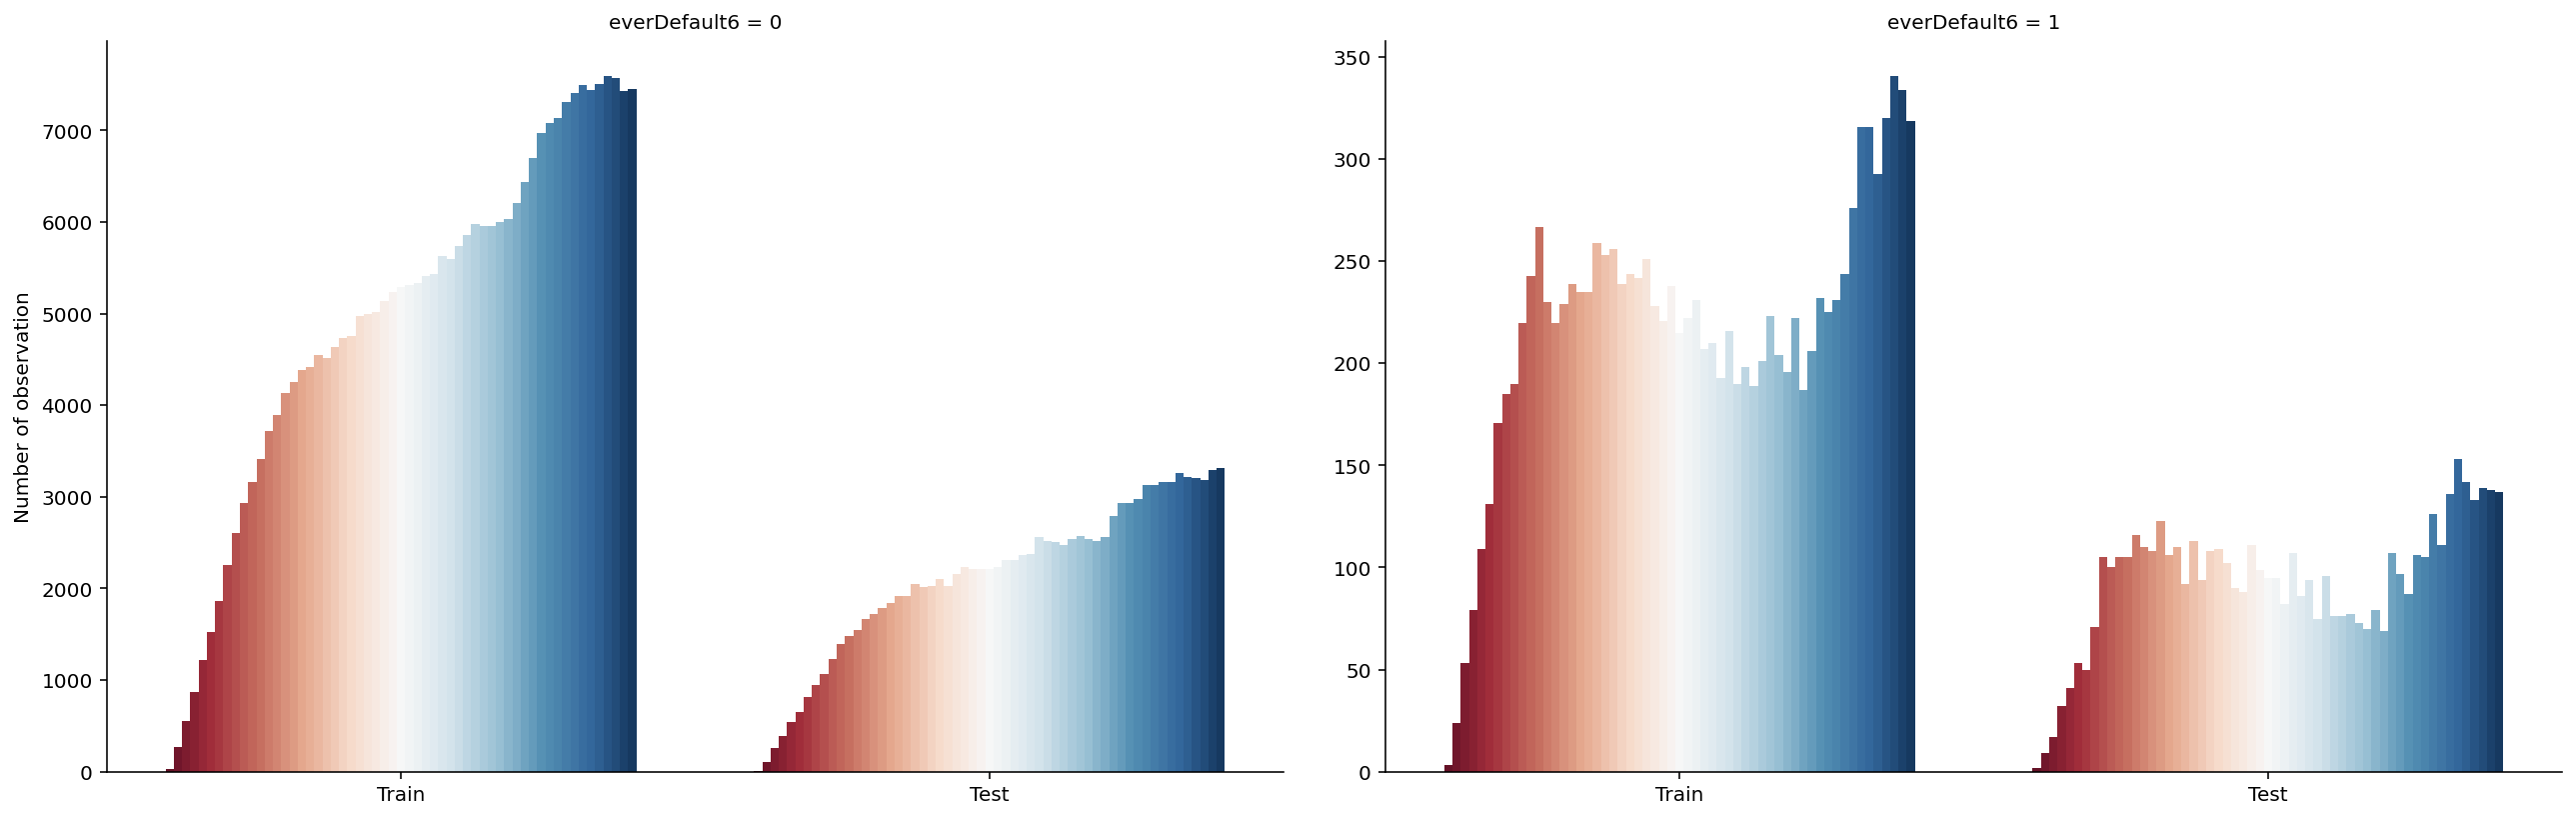

In [ ]:
# Define plot distribution function
def plotDist(trainset, testset):
  dataTrain, dataTest = trainset[['Monthkey', 'everDefault6']].copy(deep = True), testset[['Monthkey', 'everDefault6']].copy(deep = True)
  dataTrain['Sample'], dataTest['Sample'] = 'Train', 'Test'
  dataAll = pd.concat(
      [dataTrain, dataTest],
      axis = 0
  )
  ax = sns.catplot(
    x = 'Sample',
    hue = 'Monthkey',
    col = 'everDefault6',
    data = dataAll,
    kind = 'count',
    palette = 'RdBu',
    legend = False,
    sharey = False,
    height = 6,
    aspect = 1.5
  )
  ax.set_axis_labels('', 'Number of observation')
  return plt.show()

# Plot
plotDist(train, test)

In [ ]:
# Issue
# The customer is avaliable in both datasets
# Find the customer number
sampleCus = transaction['Br_Con'].sample(1).values[0]

# Define function check customer number
def checkCus(numCus, dataTrain, dataTest):
  if dataTrain['Br_Con'].str.contains(numCus).sum() > 0 and dataTest['Br_Con'].str.contains(numCus).sum() > 0:
    return print('This customer is in both datasets')
  else:
    return print('This customer is not in both datasets')

# Check
checkCus(sampleCus, train, test)

This customer is in both datasets


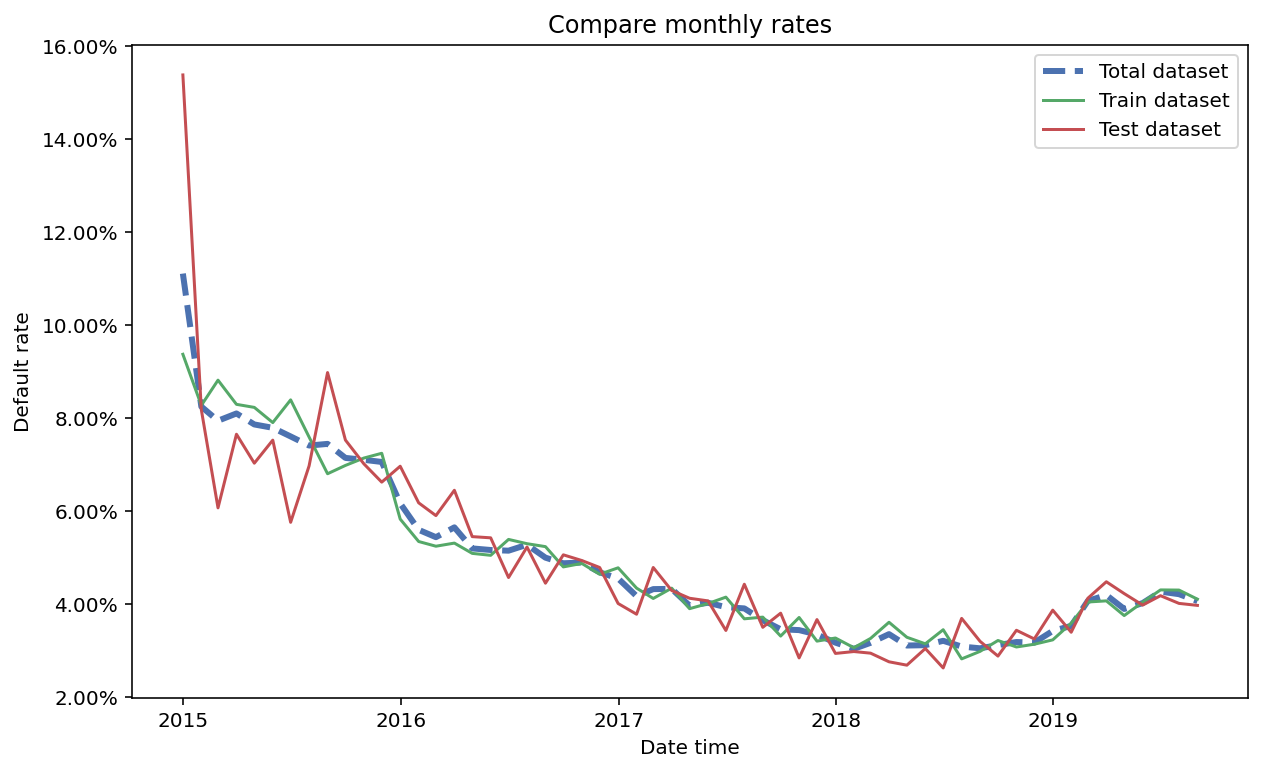

In [ ]:
# Define plot rate function
def plotRate(allset, trainset, testset):
  plt.figure(figsize = (10, 6))
  dates = pd.date_range(
      allset['AS_OF_DATE'].min(),
      allset['AS_OF_DATE'].max(),
      freq = 'M'
  )
  plt.plot(
      dates,
      allset.groupby(['Monthkey'])['everDefault6'].sum() / allset.groupby(['Monthkey'])['everDefault6'].count(),
      linewidth = 3,
      linestyle = '--',
      label = 'Total dataset'
  )
  plt.plot(
      dates,
      trainset.groupby(['Monthkey'])['everDefault6'].sum() / trainset.groupby(['Monthkey'])['everDefault6'].count(),
      label = 'Train dataset'
  )
  plt.plot(
      dates,
      testset.groupby(['Monthkey'])['everDefault6'].sum() / testset.groupby(['Monthkey'])['everDefault6'].count(),
      label = 'Test dataset'
  )
  plt.gca().set_yticklabels([f'{y * 100:.2f}%' for y in plt.gca().get_yticks()])
  plt.title('Compare monthly rates')
  plt.xlabel('Date time')
  plt.ylabel('Default rate')
  plt.legend(frameon = True, facecolor = 'white')
  return plt.show()

# Plot
plotRate(transaction, train, test)

In [ ]:
# Define sampling function
def TrainTestSplie(data, key, y, tests_size, threshold1, threshold2):
  # Parameters
  conUnique = np.unique(data[key]) #Create unique list of contract number
  totalODR = data[y].sum() / data[y].count()
  monthlyODR = data.groupby(['Monthkey'])[y].sum() / data.groupby(['Monthkey'])[y].count() 
  # Threshold
  totalThres = threshold1 #Overall ODR threshold
  monthlyThres = threshold2 #Monthly ODR threshold
  reSampling = True
  while reSampling:
    reSampling = False
    conTrain, conTest = train_test_split(conUnique, test_size = tests_size)
    # Create sampling dataset
    train = data[data[key].isin(conTrain)]
    test = data[data[key].isin(conTest)]
    # Create ODR
    trainODR = train[y].sum() / train[y].count()
    testODR = test[y].sum() / test[y].count()
    trainMonthly = train.groupby(['Monthkey'])[y].sum() / train.groupby(['Monthkey'])[y].count() 
    testMonthly = test.groupby(['Monthkey'])[y].sum() / test.groupby(['Monthkey'])[y].count()
    # Compare ODR
    diff1 = abs(totalODR - trainMonthly) > monthlyThres
    diff2 = abs(totalODR - testMonthly) > monthlyThres
    diff3 = abs(trainMonthly - testMonthly) > monthlyThres
    if (abs(totalODR - trainODR) > totalThres or
        abs(totalODR - testODR) > totalThres or
        abs(trainODR - testODR) > totalThres or
        diff1.any() or
        diff2.any() or
        diff3.any()
    ):
      print('[INFO]: Processing')
      reSampling = True
    else:
      print('[INFO]: Done')
  return train, test

In [ ]:
# Conditional train/test split
trainNew, testNew = TrainTestSplie(
    data = transaction,
    key = 'Br_Con',
    y = 'everDefault6',
    tests_size = 0.3,
    threshold1 = 0.007,
    threshold2 = 0.07
)

[INFO]: Processing
[INFO]: Processing
[INFO]: Processing
[INFO]: Processing
[INFO]: Processing
[INFO]: Processing
[INFO]: Processing
[INFO]: Processing
[INFO]: Processing
[INFO]: Processing
[INFO]: Processing
[INFO]: Processing
[INFO]: Processing
[INFO]: Processing
[INFO]: Processing
[INFO]: Processing
[INFO]: Processing
[INFO]: Processing
[INFO]: Done


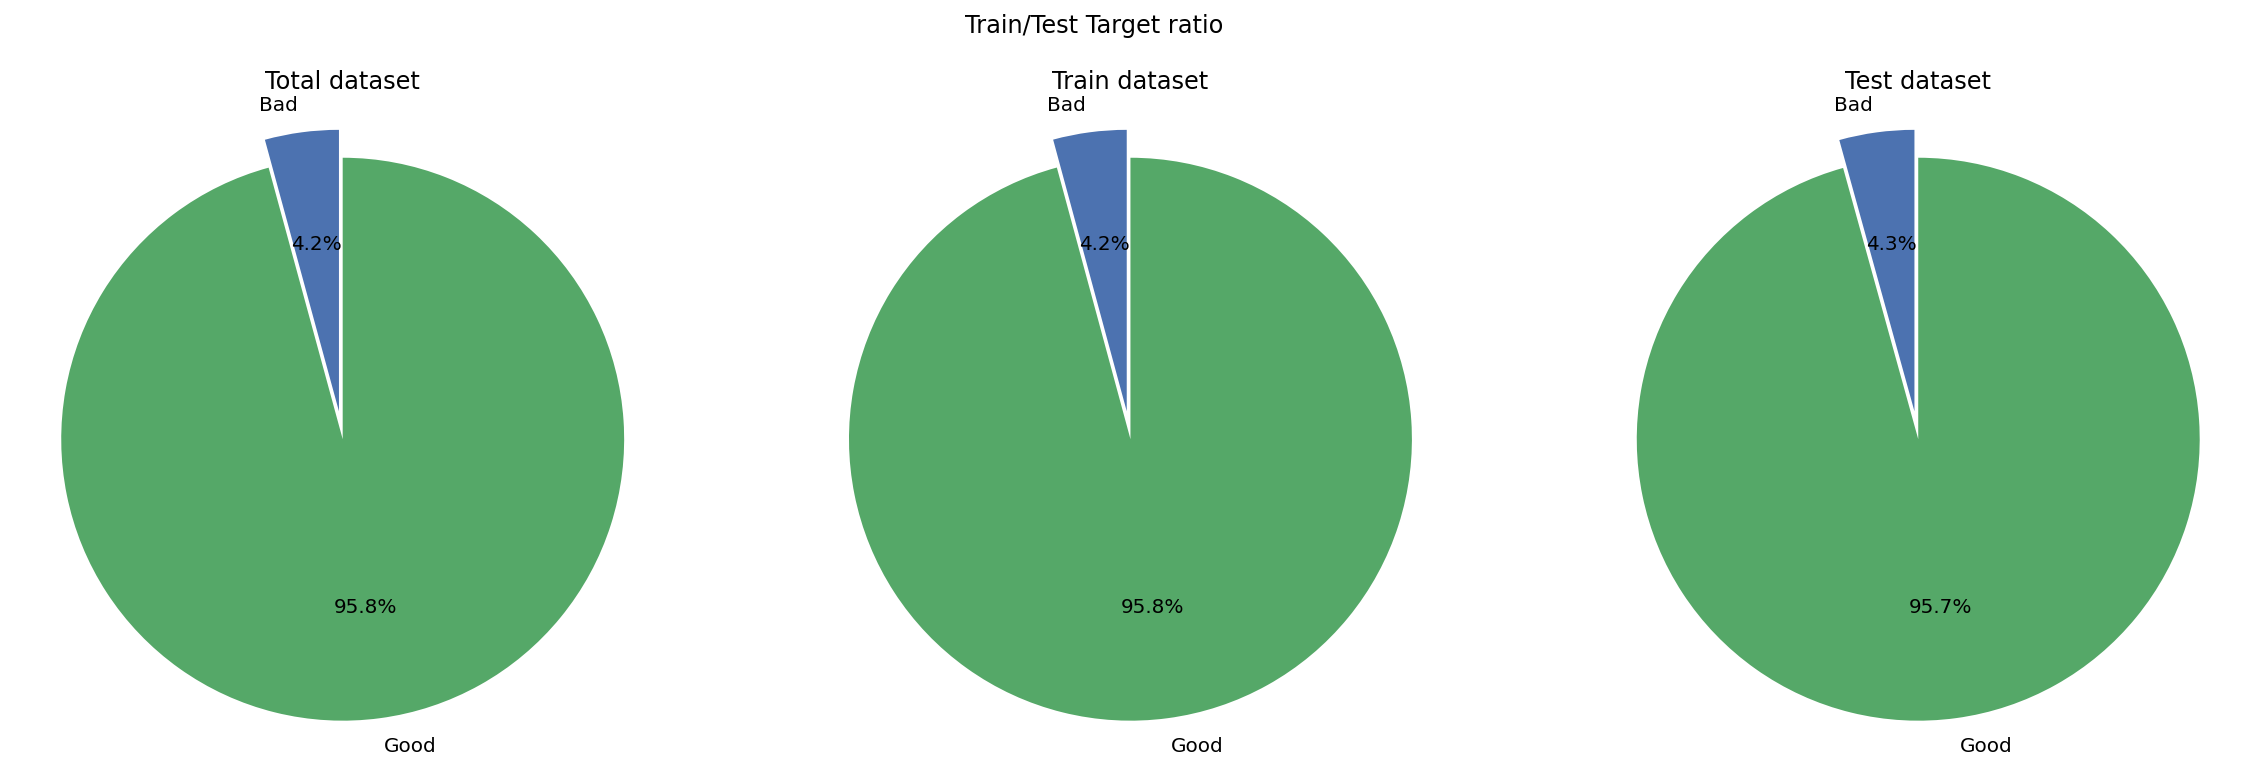

In [ ]:
# Plot sample
plotSample(transaction, trainNew, testNew)

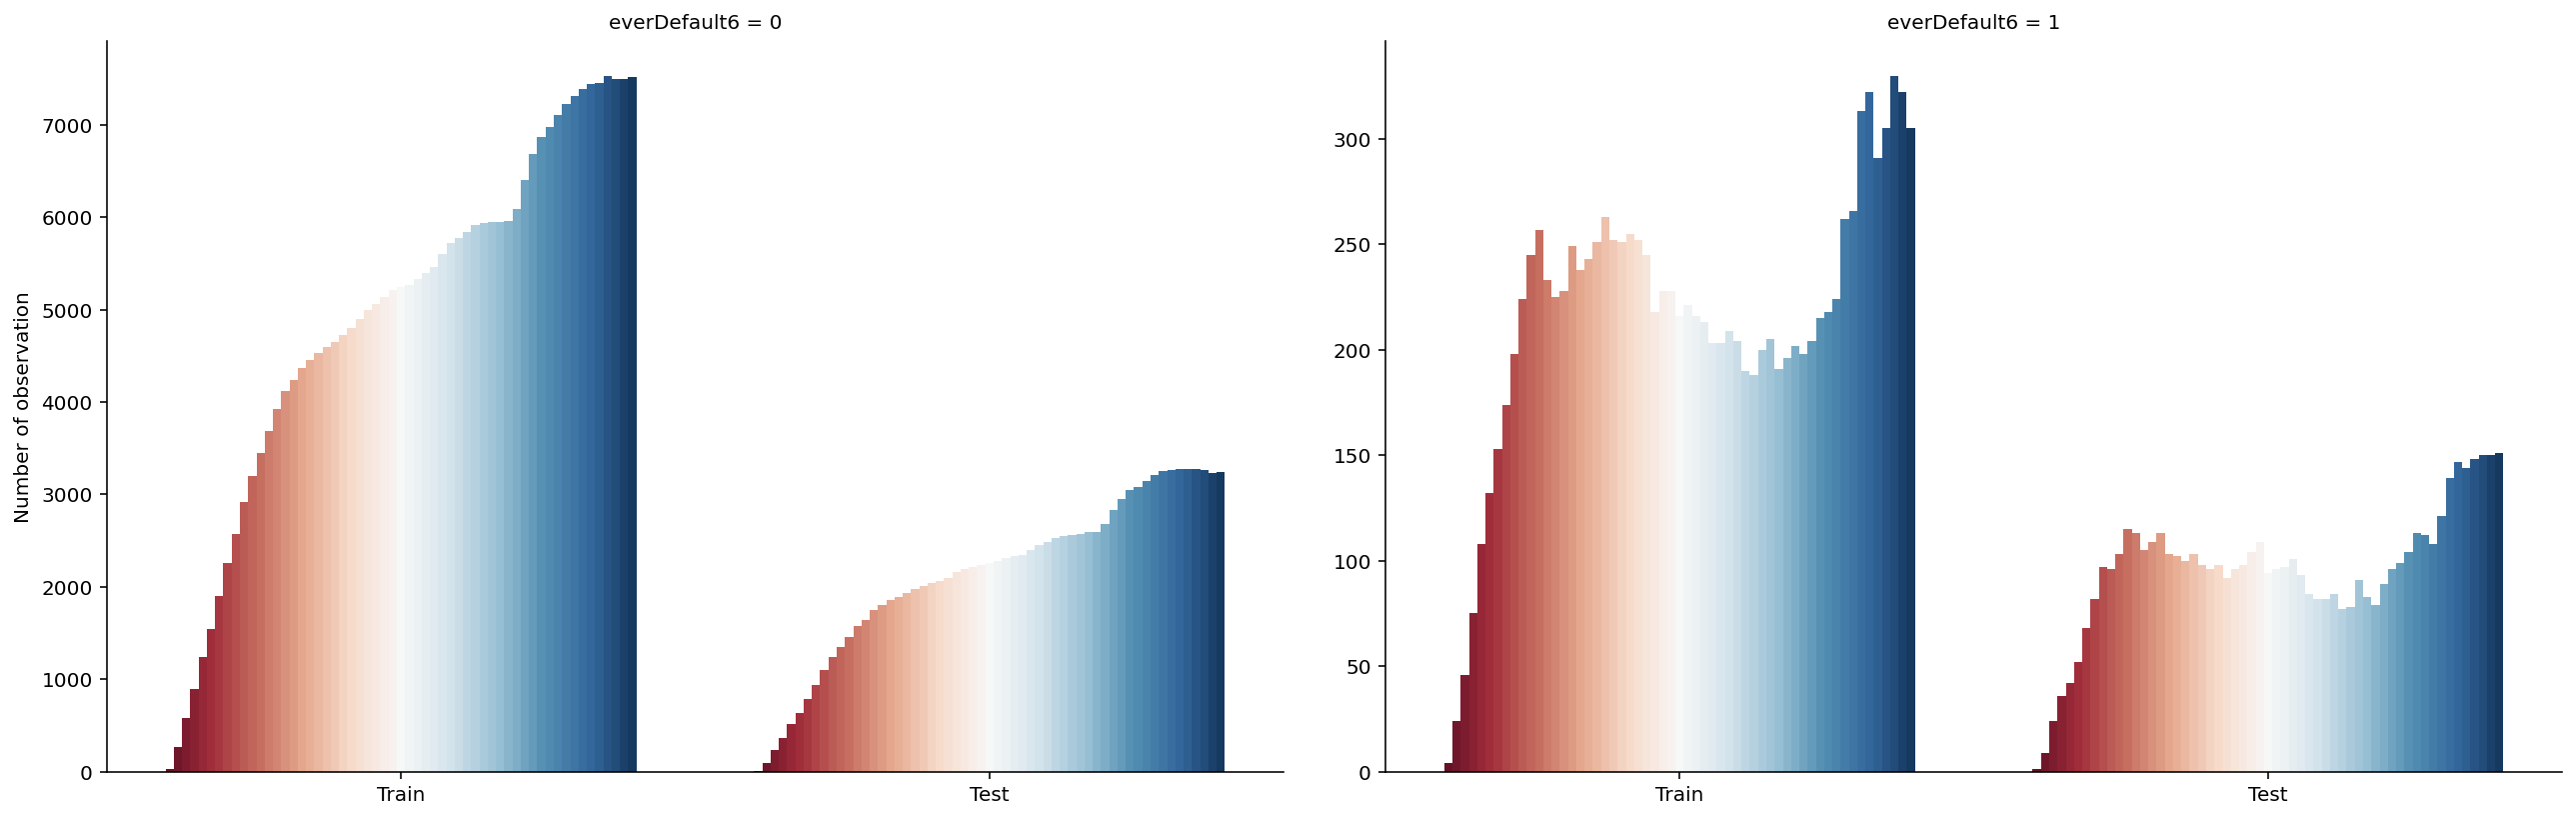

In [ ]:
# Plot distribution
plotDist(trainNew, testNew)

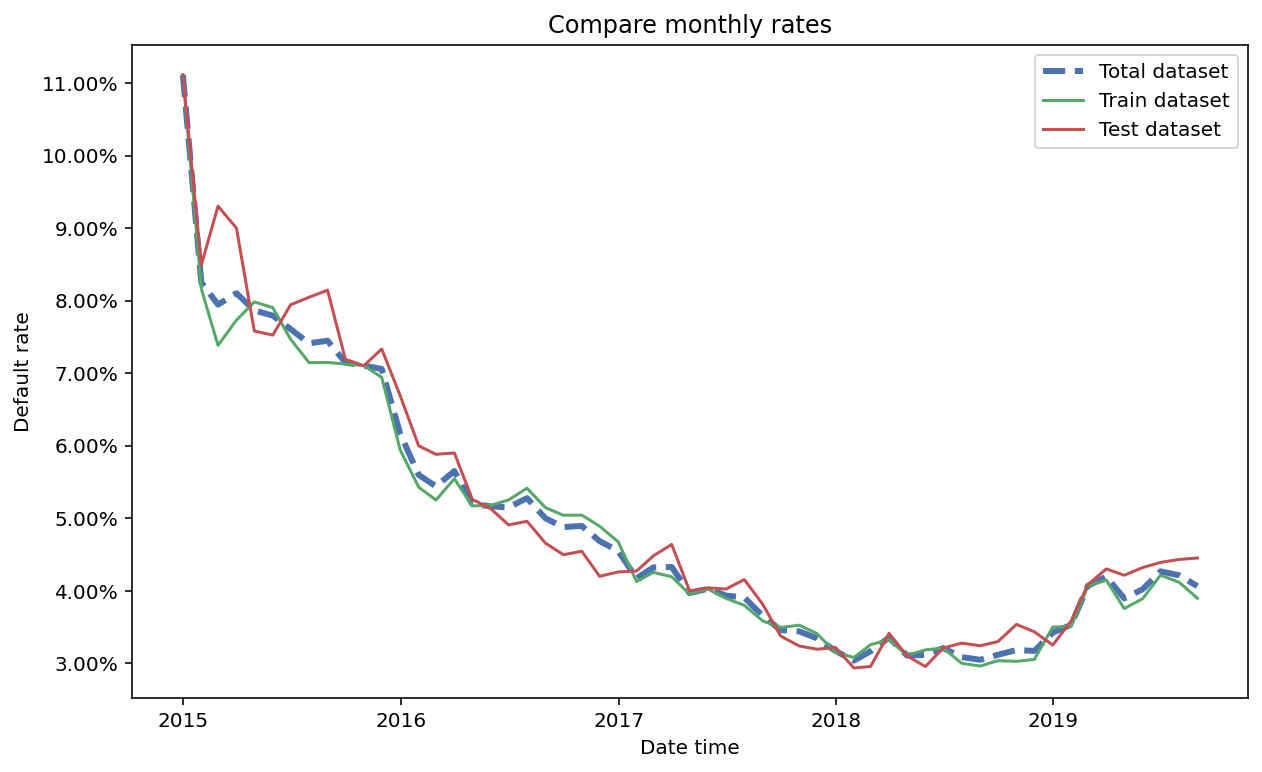

In [ ]:
# Plot rate
plotRate(transaction, trainNew, testNew)

In [ ]:
# Check
checkCus(sampleCus, trainNew, testNew)

This customer is not in both datasets


In [ ]:
# Export
trainNew.to_parquet(
    'trainTransaction.parquet',
    engine = 'pyarrow'
)
testNew.to_parquet(
    'testTransaction.parquet',
    engine = 'pyarrow'
)